In [1]:
import os
os.chdir(os.path.dirname(os.path.abspath('..')))

device_ids = [1]

# CUDA
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(map(str, device_ids))

In [2]:
import logging
import sys
from pathlib import Path
from datetime import date, datetime, timedelta
from typing import Tuple, List
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython import display

from AltimeterAutoencoder.src.save_load_model import load_model as load_autoencoder
from AltimeterAutoencoder.src.regressor import MetaRegression
from AltimeterAutoencoder.src import _types
from AltimeterAutoencoder.src.regressor import fit_regressor, MetaRegression
from Models.AttentionConvLSTMAutoEncoder import SaveLoadModels
from Models.AttentionConvLSTMAutoEncoder.training_loop import train_validation_loop
from Models.AttentionConvLSTMAutoEncoder.Seq2SeqAttention import Seq2SeqAttention, InputModel, OutputModel
from Models.Shared import Loss, DatasetParameters
from Models.Shared.Dataloader import SLADataset
from Models.AttentionConvLSTM import Attention, Encoder, Decoder
from Models.AttentionConvLSTM.Loss import create_masked_loss_function_diff

%load_ext autoreload
%autoreload 2
%matplotlib inline

def print_to_file_on_epoch(loss: Loss, _: _types.float_like, __: _types.float_like, n_epochs: int):
    logger = logging.getLogger(__name__)
    logger.info(f"Epoch: {loss.epoch:04d}/{n_epochs} Training Loss: {loss.training_loss:.7f} Validation Loss: {loss.validation_loss:.7f}")

def setup_model(
    in_channels: int,
    encoder_in_channels: int,
    encoder_out_channels: int,
    kernel_size: Tuple[int, int],
    padding: Tuple[int, int],
    frame_size: Tuple[int, int],
    hidden_output_network_channels: List[int]
) -> Seq2SeqAttention:
    # Construct models
    input_model = InputModel(in_channels, encoder_in_channels)

    encoder = Encoder(
        in_channels = encoder_in_channels,
        out_channels = encoder_out_channels,
        kernel_size = kernel_size,
        padding = padding,
        activation = nn.Tanh(),
        frame_size = frame_size,
    )

    attention = Attention(encoder_out_channels, encoder_out_channels)

    decoder = Decoder(
        in_channels = encoder_in_channels,
        hidden_channels = encoder_out_channels,
        out_channels = encoder_out_channels,
        kernel_size = kernel_size,
        padding = padding,
        activation = nn.Tanh(),
        frame_size = frame_size,
        attention = attention
    )

    output_network = OutputModel(
        in_channels = decoder.resulting_channels,
        hidden_channels = hidden_output_network_channels,
        output_channels = in_channels
    )
    return Seq2SeqAttention(input_model, encoder, decoder, output_network)

def load_model(
    model_path: Path,
    device: torch.device,
    regressor_path: Path
) -> Tuple[Seq2SeqAttention, torch.optim.Optimizer, Loss, DatasetParameters, MetaRegression, int, str]:
    model, optimizer, last_loss, dataset_parameters, auto_encoder_name = SaveLoadModels.load_checkpoint(
        model_path,
        Seq2SeqAttention,
        device
    )
    with open(regressor_path, 'rb') as file:
        regressor = MetaRegression.load(file)
    start_epoch = last_loss.epoch
    return model, optimizer, last_loss, dataset_parameters, regressor, start_epoch, auto_encoder_name

def setup_data(
    datapath: Path,
    save_path: Path,
    dataset_parameters: DatasetParameters,
    regressor: MetaRegression | None = None
) -> Tuple[DataLoader[SLADataset], DataLoader[SLADataset]]:
    with xr.open_dataset(datapath, engine="netcdf4") as file:
        file = file.sortby('time')
        sla = file['sla21'].data[:, :-1]
        times: _types.time_like = file['time'].data

    # Set train, validation and test intervals
    train_start_np = np.array(dataset_parameters.train_start).astype("datetime64[ns]")
    train_end = np.array(dataset_parameters.train_end).astype("datetime64[ns]")
    validation_end = np.array(dataset_parameters.validation_end).astype("datetime64[ns]")

    # Save times
    bool_train = (times > train_start_np) & (times <= train_end)
    bool_validation = (times > train_end) & (times <= validation_end)

    if regressor is None:
        regressor = fit_regressor(times[bool_train], sla[bool_train], save_path)

    sla -= regressor.predict(times).reshape(*sla.shape)
    train_time: _types.int_like = times[bool_train].astype("datetime64[D]").astype(int)
    validation_time: _types.int_like = times[bool_validation].astype("datetime64[D]").astype(int)

    # Save sla features
    train_features = sla[bool_train]
    validation_features = sla[bool_validation]

    # Kwargs to dataloaders
    kwargs_dataloader = {
        'shuffle': False,
        'batch_size': dataset_parameters.batch_size
    }

    # Dataloders
    train_loader = DataLoader(SLADataset(train_features, train_time, dataset_parameters), **kwargs_dataloader)
    validation_loader = DataLoader(SLADataset(validation_features, validation_time, dataset_parameters), **kwargs_dataloader)
    return train_loader, validation_loader

In [3]:
extent = [-179.5, 179.5, -64.5, 62.5]
def setup_plot_on_epoch(print_to_file: bool = True, day_number: int = 29):
    losses = []
    epochs = []
    train_loss = []
    val_loss = []
    times = []
    
    fig, axs = plt.subplots(4, 2, figsize=(14, 21))
    gs_true = axs[2, 0].get_gridspec()
    gs_pred = axs[3, 0].get_gridspec()

    # remove the underlying axes
    for ax in axs[2:, :].flatten():
        ax.remove()
    ax_example_img_true = fig.add_subplot(gs_true[2, :])
    ax_example_img_pred = fig.add_subplot(gs_pred[3, :])
    ((ax_epoch, ax_epoch_all), (ax_learningrate, ax_time)) = axs[:2, :]
    
    def update_line(loss, example_img_true, example_img_pred, total_epochs):
        # try:
        if print_to_file:
            print_to_file_on_epoch(loss, example_img_true, example_img_pred, total_epochs)

        losses.append(loss)
        train_loss.append(loss.training_loss)
        val_loss.append(loss.validation_loss)
        epochs.append(loss.epoch)

        if len(losses) > 1:
            total_seconds = (loss.time - losses[-2].time).total_seconds()/60
            estimated_next_epoch = datetime.now() + timedelta(seconds=total_seconds*60)
            times.append(total_seconds)
            fig.suptitle(f"Estimated time left: {total_seconds/60 * (total_epochs - loss.epoch):.2f} h\nEstimated next epoch: {estimated_next_epoch.strftime('%H:%M:%S')}")
            ax_time.plot(epochs[1:], times, color='red')

        ax_epoch.plot(epochs, train_loss, color='red', label="Training")
        ax_epoch.plot(epochs, val_loss, color='blue', label="Validation")
        ax_epoch.set_ylim([min(train_loss[-1], val_loss[-1])*0.9, max(train_loss[-1], val_loss[-1])*1.1])

        ax_epoch_all.plot(epochs, train_loss, color='red', label="Training")
        ax_epoch_all.plot(epochs, val_loss, color='blue', label="Validation")        

        im_pred = ax_example_img_pred.imshow(example_img_pred[day_number], extent=extent, vmin=-0.7, vmax=0.7, origin='lower', cmap='jet')
        im_true = ax_example_img_true.imshow(example_img_true[day_number], extent=extent, vmin=-0.7, vmax=0.7, origin='lower', cmap='jet')


        if len(epochs) == 1:
            ax_epoch.set_title(f"Loss")
            ax_epoch.legend(loc='upper right')
            ax_epoch.set_xlabel("Epoch")
            ax_epoch.set_ylabel("Loss")
            ax_epoch.grid()

            ax_epoch_all.set_title(f"Loss")
            ax_epoch_all.legend(loc='upper right')
            ax_epoch_all.set_xlabel("Epoch")
            ax_epoch_all.set_ylabel("Loss")
            ax_epoch_all.grid()

            ax_time.set_xlabel("Epoch")
            ax_time.set_ylabel("Time [Minutes]")
            ax_time.grid()

            ax_learningrate.set_xlabel("Epoch")
            ax_learningrate.set_ylabel("Learning rate")
            ax_learningrate.grid()

            ax_example_img_true.set_title(f"True image {day_number + 1} days")
            ax_example_img_true.set_xlabel("Lon")
            ax_example_img_true.set_ylabel("Lat")

            ax_example_img_pred.set_title(f"Prediction {day_number + 1} days")
            ax_example_img_pred.set_xlabel("Lon")
            ax_example_img_pred.set_ylabel("Lat")
            plt.colorbar(im_true, ax = ax_example_img_true)
            plt.colorbar(im_pred, ax = ax_example_img_pred)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        # except:
        #     pass
    return update_line

In [4]:
DATAPATH = Path(r"Data/Grids/without_polar_v5_mss21.nc")
SAVEFOLDER = Path("SavedModels", "ConvLSTMAttentionEncDec")
AUTOENCODERFOLDER = Path("SavedModels", "autoencoder_checkpoints")
auto_encoder_name = "checkpoint_1000epochs_128channels_unmasked.pkl"
MODEL_NAME = "checkpoint_50.pkl"
SAVEFOLDER.mkdir(parents=True, exist_ok=True)
LOAD_MODEL = True

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

logger = logging.getLogger(__name__)
stream_handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('%(asctime)s:%(message)s')
stream_handler.setFormatter(formatter)
stream_handler.setLevel(logging.DEBUG)

file_handler = logging.FileHandler(SAVEFOLDER / 'log.log')
file_handler.setFormatter(formatter)
file_handler.setLevel(logging.DEBUG)

logger.addHandler(stream_handler)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)


# Dataset parameters
default_batch_size = 5
default_sequence_length = 30
default_sequence_steps = 1
default_prediction_steps = 1
default_n_predictions = 30

# Model parameters
kernel_size = (3, 3)
padding = ((kernel_size[0] - 1)//2, (kernel_size[1] - 1)//2)
frame_size = (128, 360)
encoder_in_channels = 128
encoder_out_channels = 128
hidden_output_network_channels = [128, 128]

# Training loop
# Start: 53 - 1e-6
# Switch: 53 - 1e-3
learning_rate = 1e-3
weight_decay = 0
epochs = 100
save_every = 10
n_sequences = 30
scheduler = None
teacher_forcing_ratio_list: List[float] = [0]*epochs

In [5]:
# Loss
criterion = create_masked_loss_function_diff(nn.MSELoss)

regressor = None
if LOAD_MODEL:
    model, optimizer, last_loss, dataset_parameters, regressor, start_epoch, auto_encoder_name = load_model(
        SAVEFOLDER / MODEL_NAME,
        DEVICE,
        SAVEFOLDER / "Regression.pkl"
    )

In [6]:
# Load autoencoder
encoder, decoder, _, _, _, fill_nan, _, train_start, train_end, validation_end = load_autoencoder(
    AUTOENCODERFOLDER / auto_encoder_name,
    DEVICE
)

In [24]:
# optimizer.param_groups[0]['lr'] = 1e-3

In [7]:
if not LOAD_MODEL:
    dataset_parameters = DatasetParameters(
        batch_size = default_batch_size,
        sequence_length = default_sequence_length,
        sequence_steps = default_sequence_steps,
        prediction_steps = default_prediction_steps,
        fill_nan = fill_nan,
        train_start = train_start,
        train_end = train_end,
        validation_end = validation_end,
        n_predictions = default_n_predictions,
    )
    start_epoch = 0

    model = setup_model(
        in_channels = encoder.feature_dimension,
        encoder_in_channels = encoder_in_channels,
        encoder_out_channels = encoder_out_channels,
        kernel_size = kernel_size,
        padding = padding,
        frame_size = encoder.get_out_frame_size(frame_size),
        hidden_output_network_channels = []
    ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

try:
    with open(SAVEFOLDER / "Regression.pkl", 'rb') as file:
        regressor = MetaRegression.load(file)
except:
    regressor = None
    
train_loader, validation_loader = setup_data(
    DATAPATH,
    SAVEFOLDER / "Regression.pkl",
    dataset_parameters, # type: ignore
    regressor
)

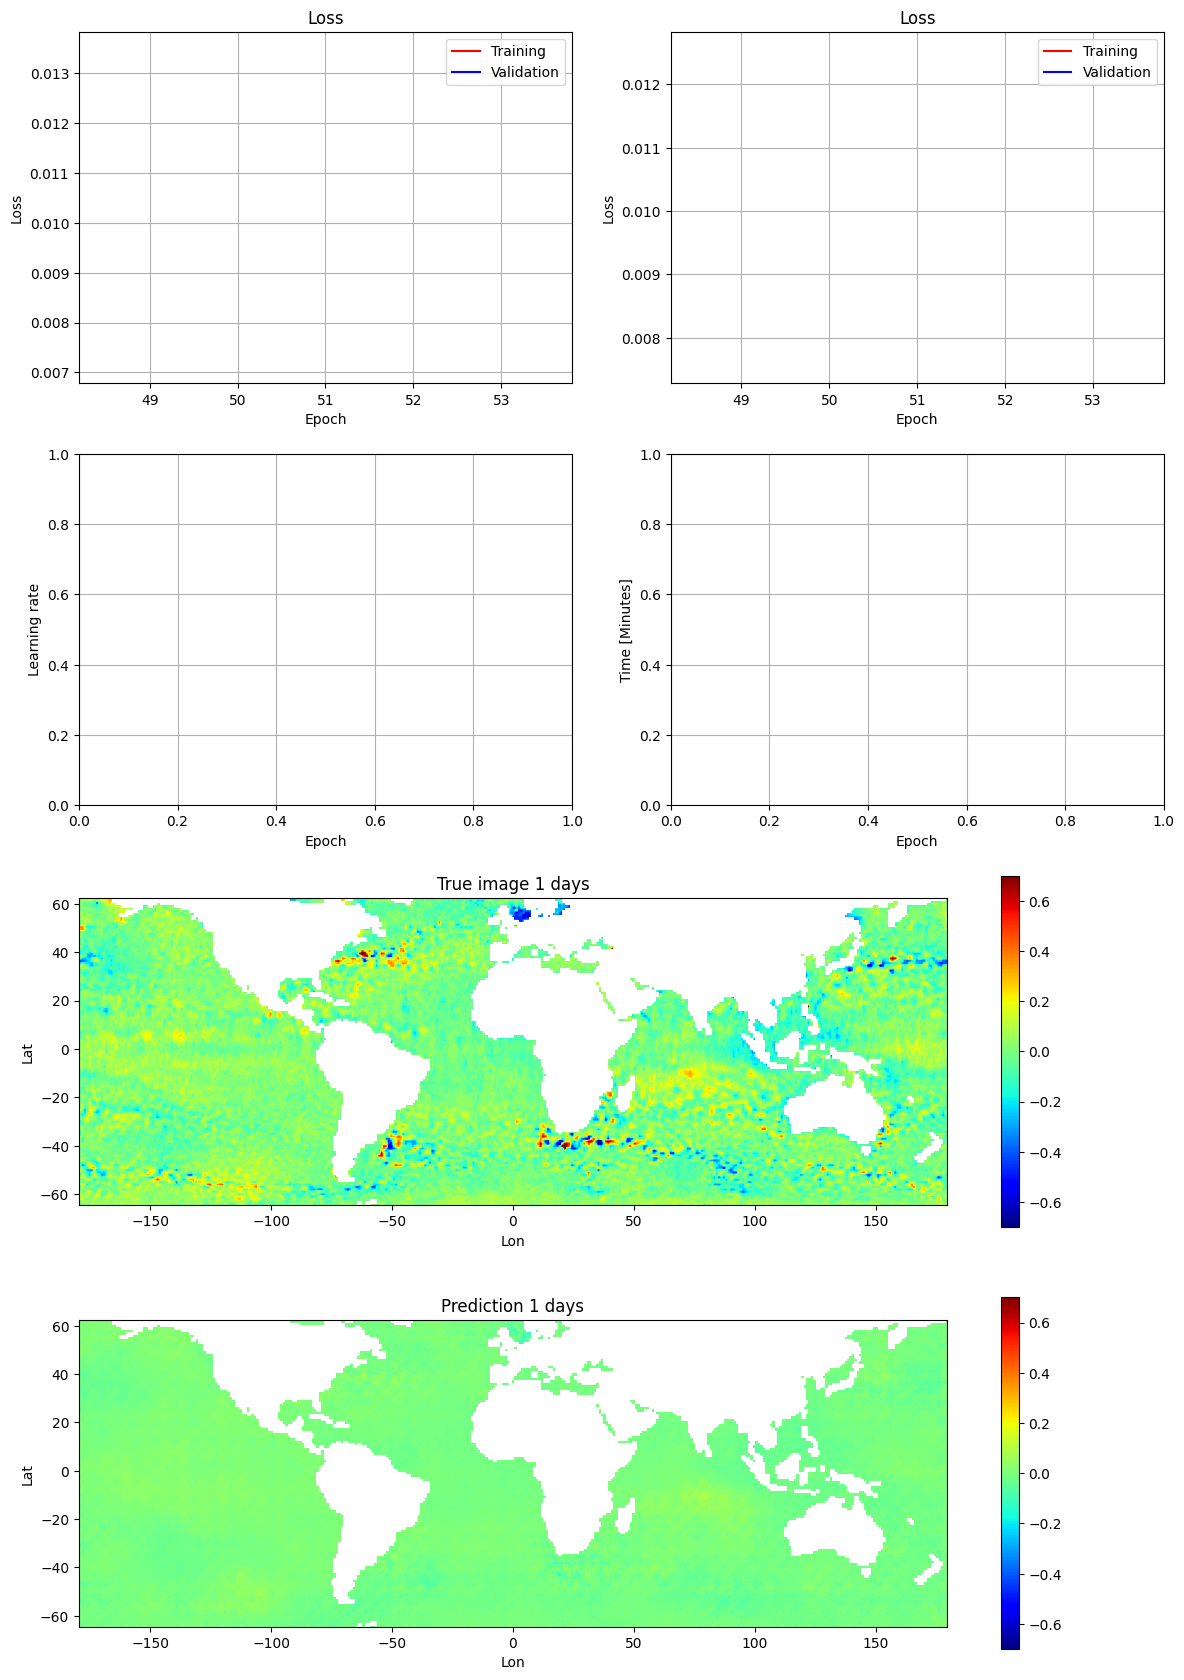

In [ ]:
# Train
for i in range(100):
    try:
        scheduler = None
        losses = train_validation_loop(
            encoder = encoder,
            decoder = decoder,
            model = model, # type: ignore
            train_loader = train_loader,
            val_loader = validation_loader,
            criterion = criterion,
            optimizer = optimizer, # type: ignore
            num_epochs = epochs,
            start_epoch = start_epoch, # type: ignore
            device = DEVICE,
            update_function = setup_plot_on_epoch(True, 0),
            path = SAVEFOLDER,
            save_n_epochs = save_every,
            dataset_parameters = dataset_parameters, # type: ignore
            teacher_forcing_ratios = teacher_forcing_ratio_list,
            losses = None,
            scheduler = scheduler,
            n_sequences = n_sequences,
            encoder_filename = auto_encoder_name
        )
        plt.close()
        break
    except ValueError as ex:
        plt.close()
        if not LOAD_MODEL:
            raise ex
        model = setup_model(
            in_channels = encoder.feature_dimension,
            encoder_in_channels = encoder_in_channels,
            encoder_out_channels = encoder_out_channels,
            kernel_size = kernel_size,
            padding = padding,
            frame_size = encoder.get_out_frame_size(frame_size),
            hidden_output_network_channels = hidden_output_network_channels
        ).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        print(f"{datetime.now()} | Failed {i} times", end='\r')

In [8]:
with torch.no_grad():
    while True:
        features, target, mask, _, result_time = next(iter(validation_loader))
        # Save time
        batch_size = result_time.size(0)
        target_times = result_time.numpy()

        if torch.any(torch.all(torch.all(mask, dim=3), dim=2)):
            continue

        # Move to device
        features = features.to(DEVICE)
        target = target.to(DEVICE)
        mask = mask.to(DEVICE)

        # Predict
        latent_space, output = model.get_latent_space(encoder, decoder, features, None, n_sequences, 0)
        target = target.squeeze(1)
        output[mask] = np.nan
        target[mask] = np.nan
        output = output.detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        break

In [9]:
latent_space = latent_space.detach().cpu().numpy()

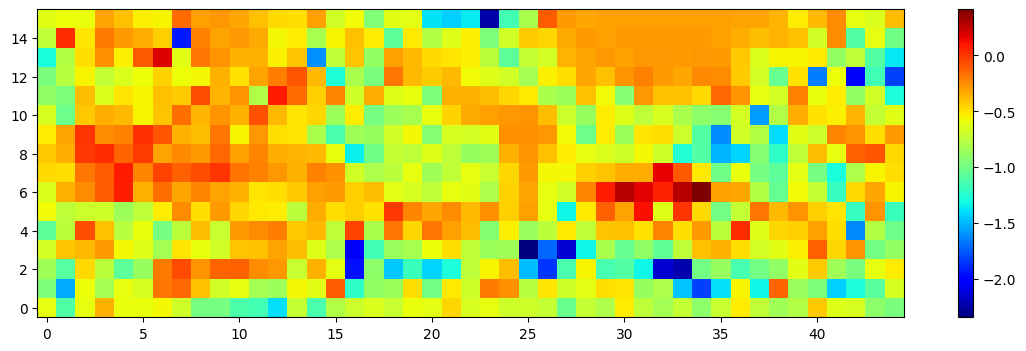

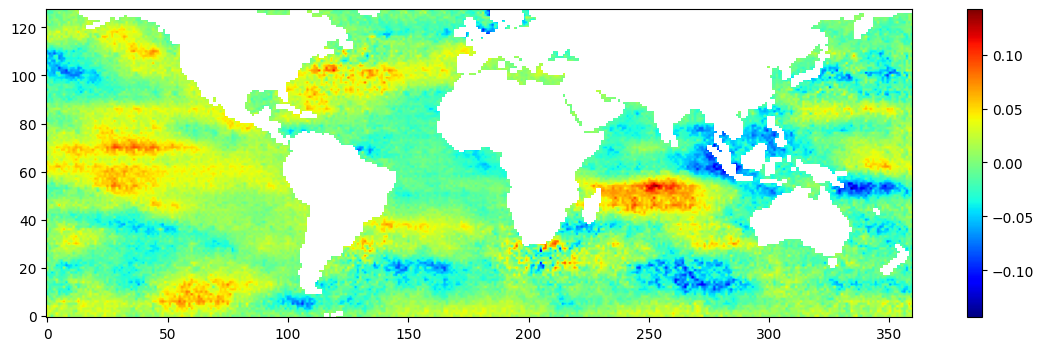

In [13]:
batch_id = 0
channel_id = 0
day_id = 0
plt.figure(figsize=(14,4))
plt.imshow(latent_space[batch_id, channel_id, day_id], origin='lower', cmap='jet')
plt.colorbar()
plt.show()
plt.figure(figsize=(14,4))
plt.imshow(output[batch_id, day_id], origin='lower', cmap='jet')
plt.colorbar()
plt.show()

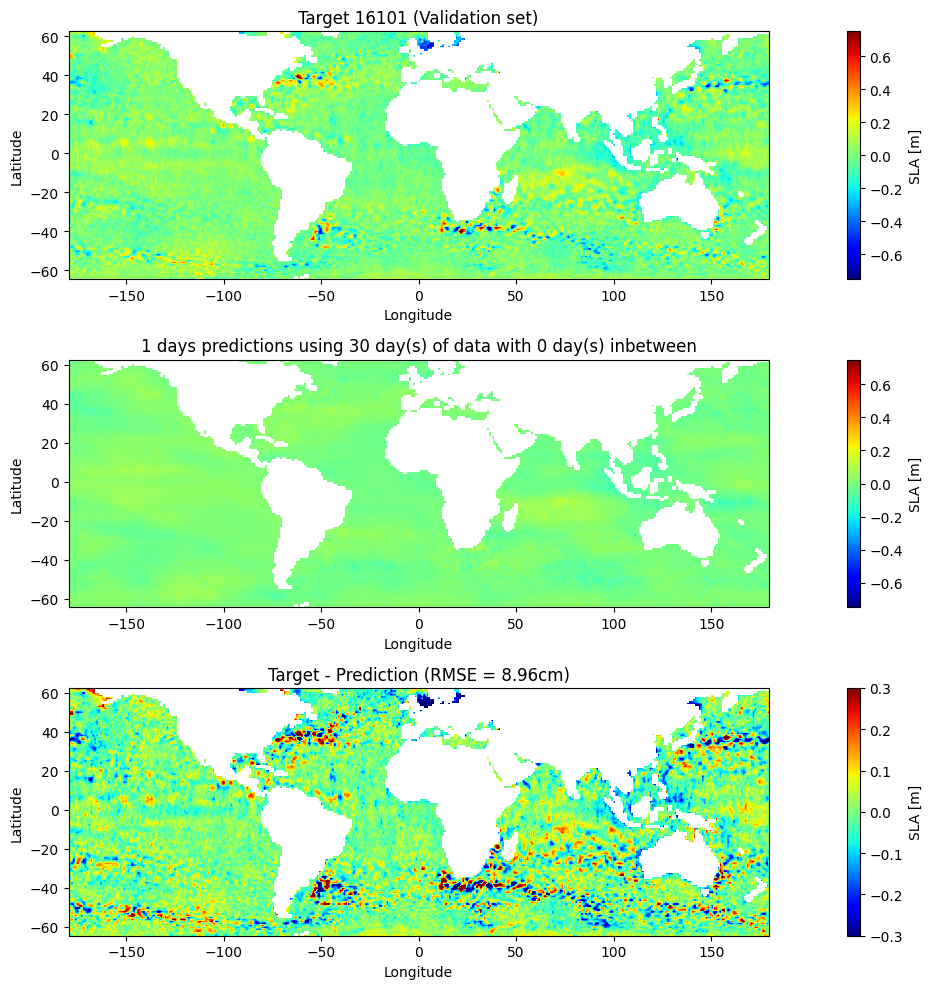

In [12]:
import cmcrameri.cm as cmc

def get_pred_title_multi(dataset_parameters: DatasetParameters, n_predictions: int):
    return f"{n_predictions * dataset_parameters.prediction_steps} days predictions using {dataset_parameters.sequence_length} day(s) of data\nwith {dataset_parameters.sequence_steps - 1} day(s) inbetween"

def get_pred_title(dataset_parameters: DatasetParameters, n_predictions: int):
    return get_pred_title_multi(dataset_parameters, n_predictions).replace('\n', ' ')

idx = 0
day_prediction = 0

vmin = -0.75
vmax = 0.75
cmap = 'jet'

vmin_diff = -0.3
vmax_diff = 0.3

diffs = target - output
diff_data = diffs[idx, day_prediction]
diff_vector = diff_data[~np.isnan(diff_data)].flatten()
rmse = np.sqrt(diff_vector @ diff_vector / len(diff_vector))

fig, axes = plt.subplots(3, 1, figsize=(16,10))
im_target = axes[0].imshow(target[idx, day_prediction], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_pred = axes[1].imshow(output[idx, day_prediction], origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)
im_diff = axes[2].imshow(diff_data, origin='lower', extent=extent, vmin=vmin_diff, vmax=vmax_diff, cmap=cmap)

axes[0].set_title(f"Target {target_times[idx, day_prediction]} (Validation set)")
axes[1].set_title(get_pred_title(dataset_parameters, day_prediction + 1))
axes[2].set_title(f"Target - Prediction (RMSE = {rmse*100:.2f}cm)")

for ax in axes.flatten():
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")

caxs = []
caxs.append(fig.colorbar(im_target))
caxs.append(fig.colorbar(im_pred))
caxs.append(fig.colorbar(im_diff))

for cax in caxs:
    cax.ax.set_ylabel("SLA [m]")

plt.tight_layout()
plt.show()